# Call Center Data

In [1]:
library(survival)

In this section, we will simulate survival data using the `sim.survdata()` function, which is part of teh `coxed` library. Our simulated data will represent the observed wait times (in seconds) for $2,000$ customers who have phoned a call center. In this context, censoring occurs if a customer hangs up before his or her call is answered.  
There are three covariates: `Operators` (the number of call center operators available at the time of the call, which can range from 5 to 15), `Center` (either A, B, or C), and `Time` of day (Morning, Afternoon, or evening). We generate data for these covariates so that all possibilities are equally likely: for instance, morning, afternoon and evening calls are equally likely, and any number of operators from 5 to 15 is equally likely.

In [2]:
set.seed(4)
N <- 2000
Operators <- sample(5:15, N, replace = T)
Center <- sample(c("A", "B", "C"), N, replace = T)
Time <- sample(c("Morn.", "After.", "Even."), N, replace = T)
X <- model.matrix( ~ Operators + Center + Time)[, -1]

It is worthwile to take a peek at the design matrix $X$, so that we can be sure that we understand how the variables have been coded.

In [3]:
X[1:5,]

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.
1,12,1,0,0,1
2,15,0,0,0,0
3,7,0,1,1,0
4,7,0,0,0,0
5,11,0,1,0,1


Next, we specify the coefficients and the hazard function.

In [4]:
true.beta <- c(0.04, -0.3, 0, 0.2, -0.2)
h.fn <- function(x) return(0.00001 * x)

Here, we have set the coeefficient associated with `Operators` to equal $0.04$; in other words, each additional operator leads to a $e^{0.04} = 1.041$-fold increase in the "risk" that the call will be answered, given the `Center` and `Time` covariates. This makes sense: the greater the number of operators at hand, the shorter the wait time! The coefficient associated with `Center  = B` is $-0.3$, and `Center = A` is treated as the baseline. This means that the risk of a call being answered at Center B is $0.74$ times the risk that it will be answered at Center A; in other words the wait times are a bit longer at Center B.  
We are now ready to generate data under Cox proportional hazards model. The `sim.survdata()` function allows us to specify the maximum possible failure time, which in this case corresponds to the longest possible wait time for a customer; we set this to equal $1,000$ seconds.

In [5]:
library(coxed)
queuing <- sim.survdata(N = N, T = 1000, X = X,
    beta = true.beta, hazard.fun = h.fn)
names(queuing)

Loading required package: rms

Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Loading required package: mgcv

Loading required package: nlme

This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Warning message in FUN(X[[i]], ...):
“9 additional observations right-censored because the user-supplied hazard function
                                  is nonzero at the latest timepoint. To avoid these extra censored observations, increase T”


[1] "data"             "xdata"            "baseline"         "xb"              
[5] "exp.xb"           "betas"            "ind.survive"      "marg.effect"     
[9] "marg.effect.data"

The "observed" data is stored in `queuing$data`, with `y` corresponding to the event time and `failed` an indicator of whether the call was answered (`failed = T`) or the customer hung up before the call was answered (`failed = F`). We see that almost $90\%$ of calls were answered

In [6]:
head(queuing$data)

,Operators,CenterB,CenterC,TimeEven.,TimeMorn.,y,failed
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
1,12,1,0,0,1,344,TRUE
2,15,0,0,0,0,241,TRUE
3,7,0,1,1,0,187,TRUE
4,7,0,0,0,0,279,TRUE
5,11,0,1,0,1,954,TRUE
6,7,1,0,0,1,455,TRUE


In [7]:
mean(queuing$data$failed)

[1] 0.89

We now plot Kaplan-Meier survival curves. First, we stratify by `Center`

Next, we stratify by `Time`.

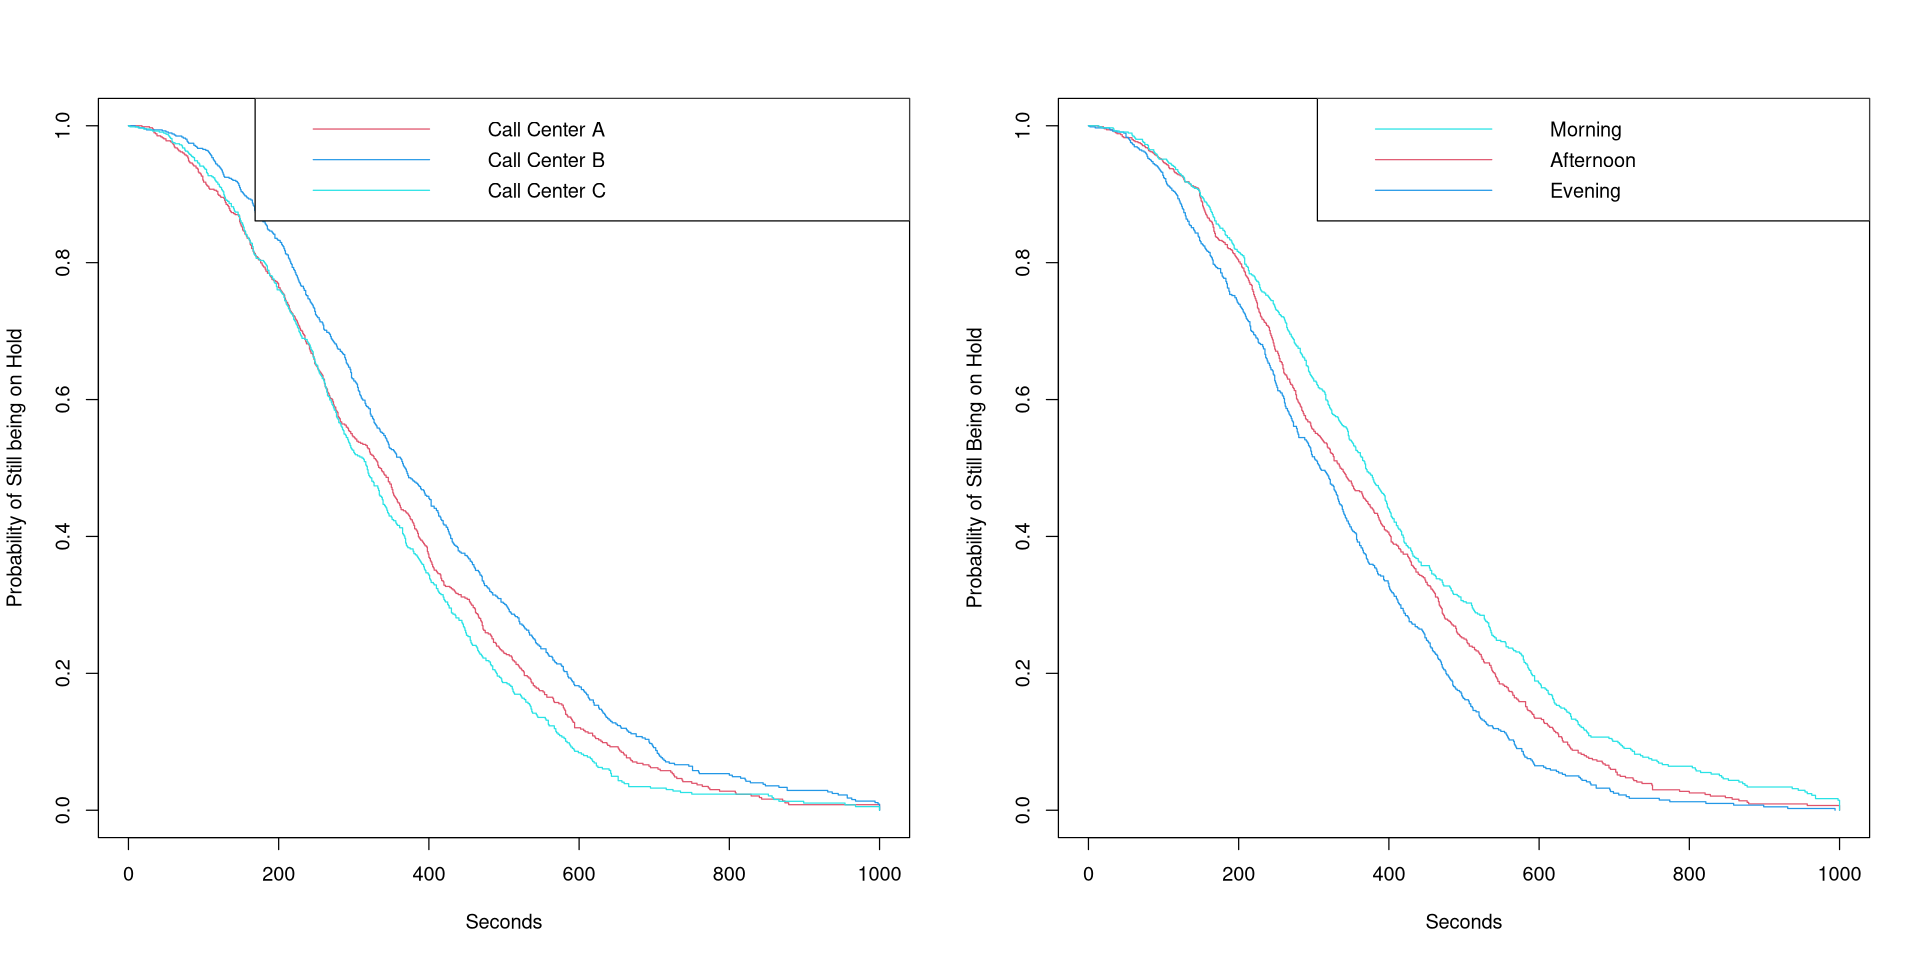

In [8]:
par(mfrow = c(1, 2))
options(repr.plot.width=16, repr.plot.height=8)
fit.Center <- survfit(Surv(y, failed) ~ Center,
    data = queuing$data)
plot(fit.Center, xlab = "Seconds",
     ylab = "Probability of Still being on Hold",
     col = c(2, 4, 5))
legend("topright",
       c("Call Center A", "Call Center B", "Call Center C"),
       col = c(2, 4, 5), lty = 1)
fit.Time <- survfit(Surv(y, failed) ~ Time,
    data = queuing$data)
plot(fit.Time, xlab = "Seconds",
     ylab = "Probability of Still Being on Hold",
     col = c(2, 4, 5))
legend("topright", c("Morning", "Afternoon", "Evening"),
       col = c(5, 2, 4), lty = 1)

It seems that calls at Call Center B take longer to be answered than calls at Centers A and C. SImilarly, it appears that wait times are longest in the morning and shortest in the evening hours. We can use a log-rank test to determine whether these differences are statistically significant.

In [9]:
survdiff(Surv(y, failed) ~ Center, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Center, data = queuing$data)

           N Observed Expected (O-E)^2/E (O-E)^2/V
Center=A 683      603      579     0.971      1.45
Center=B 667      600      701    14.641     24.64
Center=C 650      577      499    12.062     17.05

 Chisq= 28.3  on 2 degrees of freedom, p= 7e-07 

In [10]:
survdiff(Surv(y, failed) ~ Time, data = queuing$data)

Call:
survdiff(formula = Surv(y, failed) ~ Time, data = queuing$data)

              N Observed Expected (O-E)^2/E (O-E)^2/V
Time=After. 688      616      619    0.0135     0.021
Time=Even.  653      582      468   27.6353    38.353
Time=Morn.  659      582      693   17.7381    29.893

 Chisq= 46.8  on 2 degrees of freedom, p= 7e-11 

We find that differences between centers are highly significant, as are differences between times of day.  
Finally, we fit Cox's proportional hazards model to the data.

In [11]:
fit.queuing <- coxph(Surv(y, failed) ~ .,
    data = queuing$data)
fit.queuing

Call:
coxph(formula = Surv(y, failed) ~ ., data = queuing$data)

              coef exp(coef) se(coef)      z        p
Operators  0.04174   1.04263  0.00759  5.500  3.8e-08
CenterB   -0.21879   0.80349  0.05793 -3.777 0.000159
CenterC    0.07930   1.08253  0.05850  1.356 0.175256
TimeEven.  0.20904   1.23249  0.05820  3.592 0.000328
TimeMorn. -0.17352   0.84070  0.05811 -2.986 0.002828

Likelihood ratio test=102.8  on 5 df, p=< 2.2e-16
n= 2000, number of events= 1780 

The _p_-values for `Center = B, Time = Even.` and `Time = Morn.` are very small. It is also clear that the hazard&mdash;that is, the instantaneous risk that a call will be answered&mdash;increases with the number of operators. Since we generated the data ourselves, we know that the true coefficients for `Operators`, `Center = B`, `Center = C`, `Time = Even.` and `Time = Morn.` are $0.04, -0.3, 0, 0.2,$ and $-0.2$, respectively. The coefficient estimates resulting from the Cox model are fairly accurate.